# 모형 결합의 기초

모형 결합(model combining) 방법은 앙상블 방법론(ensemble methods)이라고도 한다. 이는 특정한 하나의 예측 방법이 아니라 복수의 예측 모형을 결합하여 더 나은 성능의 예측을 하려는 시도이다. 

모형 결합 방법을 사용하면 일반적으로 계산량은 증가하지만 다음과 같은 효과가 있다.

* 단일 모형을 사용할 때 보다 성능 분산이 감소하고, 즉 과최적화를 방지한다.
* 개별 모형이 성능이 안좋을 경우에는 결합 모형의 성능이 더 향상된다.

모형 결합 방법은 크게 나누어 취합(aggregation) 방법론과 부스팅(boosting) 방법론으로 나눌 수 있다.

* 취합 방법론은 사용할 모형의 집합이 이미 결정되어 있지만
* 부스팅 방법론은 사용할 모형을 점진적으로 늘려간다.

각 방법론의 대표적인 방법들은 아래와 같다.

* 취합 방법론
 * 다수결 (Majority Voting)
 * 배깅 (Bagging)
 * 랜덤 포레스트 (Random Forests)

* 부스팅 방법론
 * 에이다부스트 (AdaBoost)
 * 그레디언트 부스트 (Gradient Boost)
 
 
여기에서는 일단 취합 방법에 대해 살펴본다.

## 다수결 방법

다수결 방법은 가장 단순한 모형 결합 방법으로 전혀 다른 모형도 결합할 수 있다. 다수결 방법은 Hard Voting 과 Soft Voting 두 가지로 나뉘어진다. 

* hard voting: 단순 투표. 개별 모형의 결과 기준
* soft voting: 가중치 투표. 개별 모형의 조건부 확률의 합 기준
 


Scikit-Learn 의 ensemble 서브패키지는 다수결 방법을 위한 [`VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) 클래스를 제공한다.


`sklearn.ensemble.VotingClassifier(estimators, voting='hard', weights=None)`

* 입력 인수:	
 * `estimators` : 
    * 개별 모형 목록, 리스트나 named parameter 형식으로 입력
 * `voting` : 문자열 {‘hard’, ‘soft’} (디폴트 ’hard’)
    * hard voting 과 soft voting 선택
 * `weights` : 리스트
    * 사용자 가중치



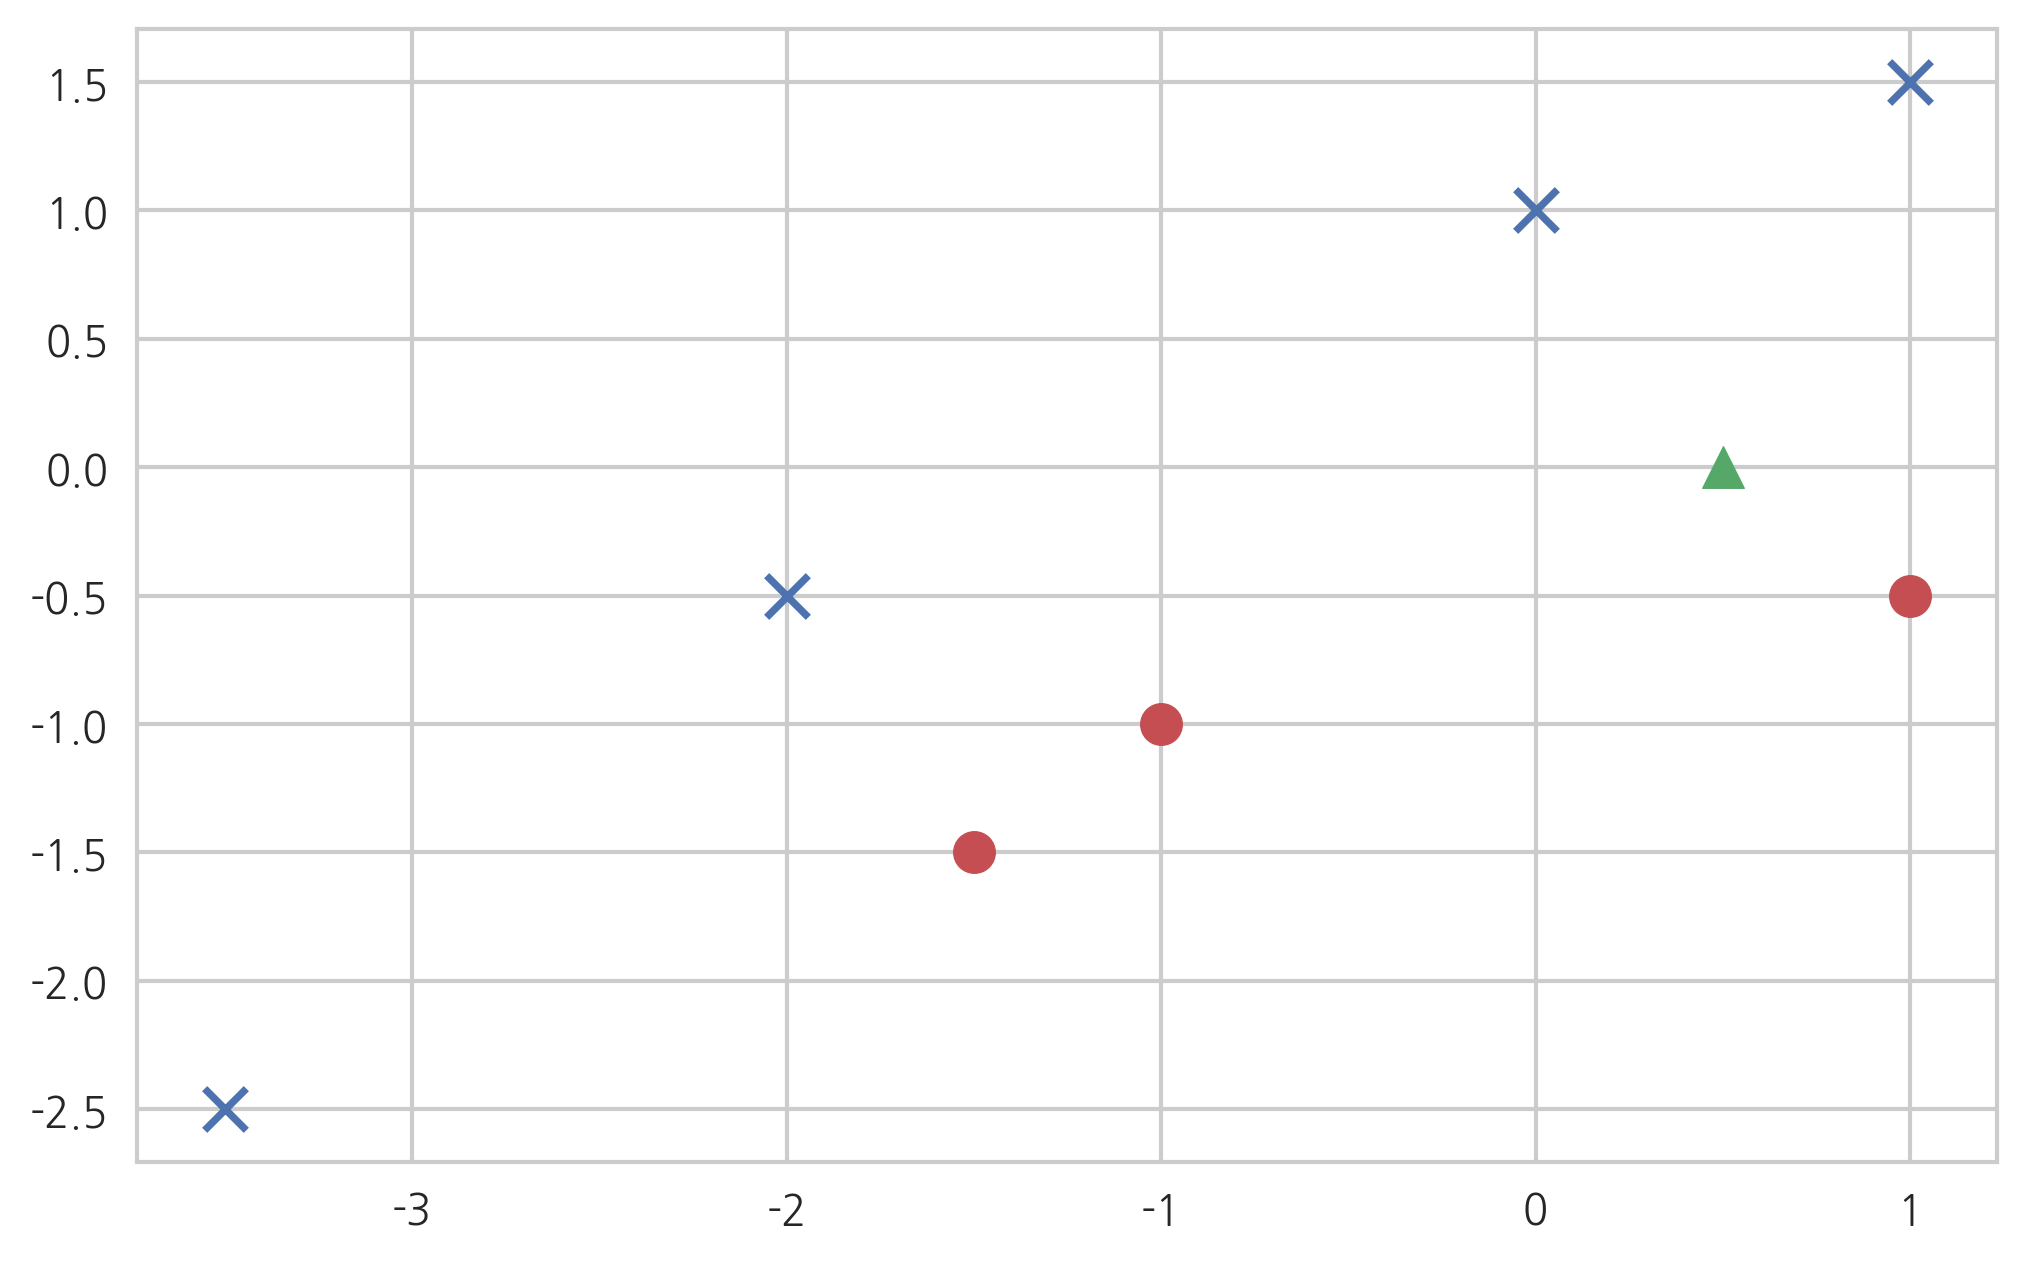

In [1]:
X = np.array([[-1, -1], [-1.5, -1.5], [1, -0.5], 
              [-3.5, -2.5], [0, 1], [1, 1.5], [-2, -0.5]])
y = np.array([1, 1, 1, 2, 2, 2, 2])

plt.scatter(X[y==1,0], X[y==1,1], s=100, marker='o', c='r')
plt.scatter(X[y==2,0], X[y==2,1], s=100, marker='x', c='b')

x_new = [0.5, 0]

plt.scatter(x_new[0], x_new[1], s=100, marker='^', c='g')
plt.show()

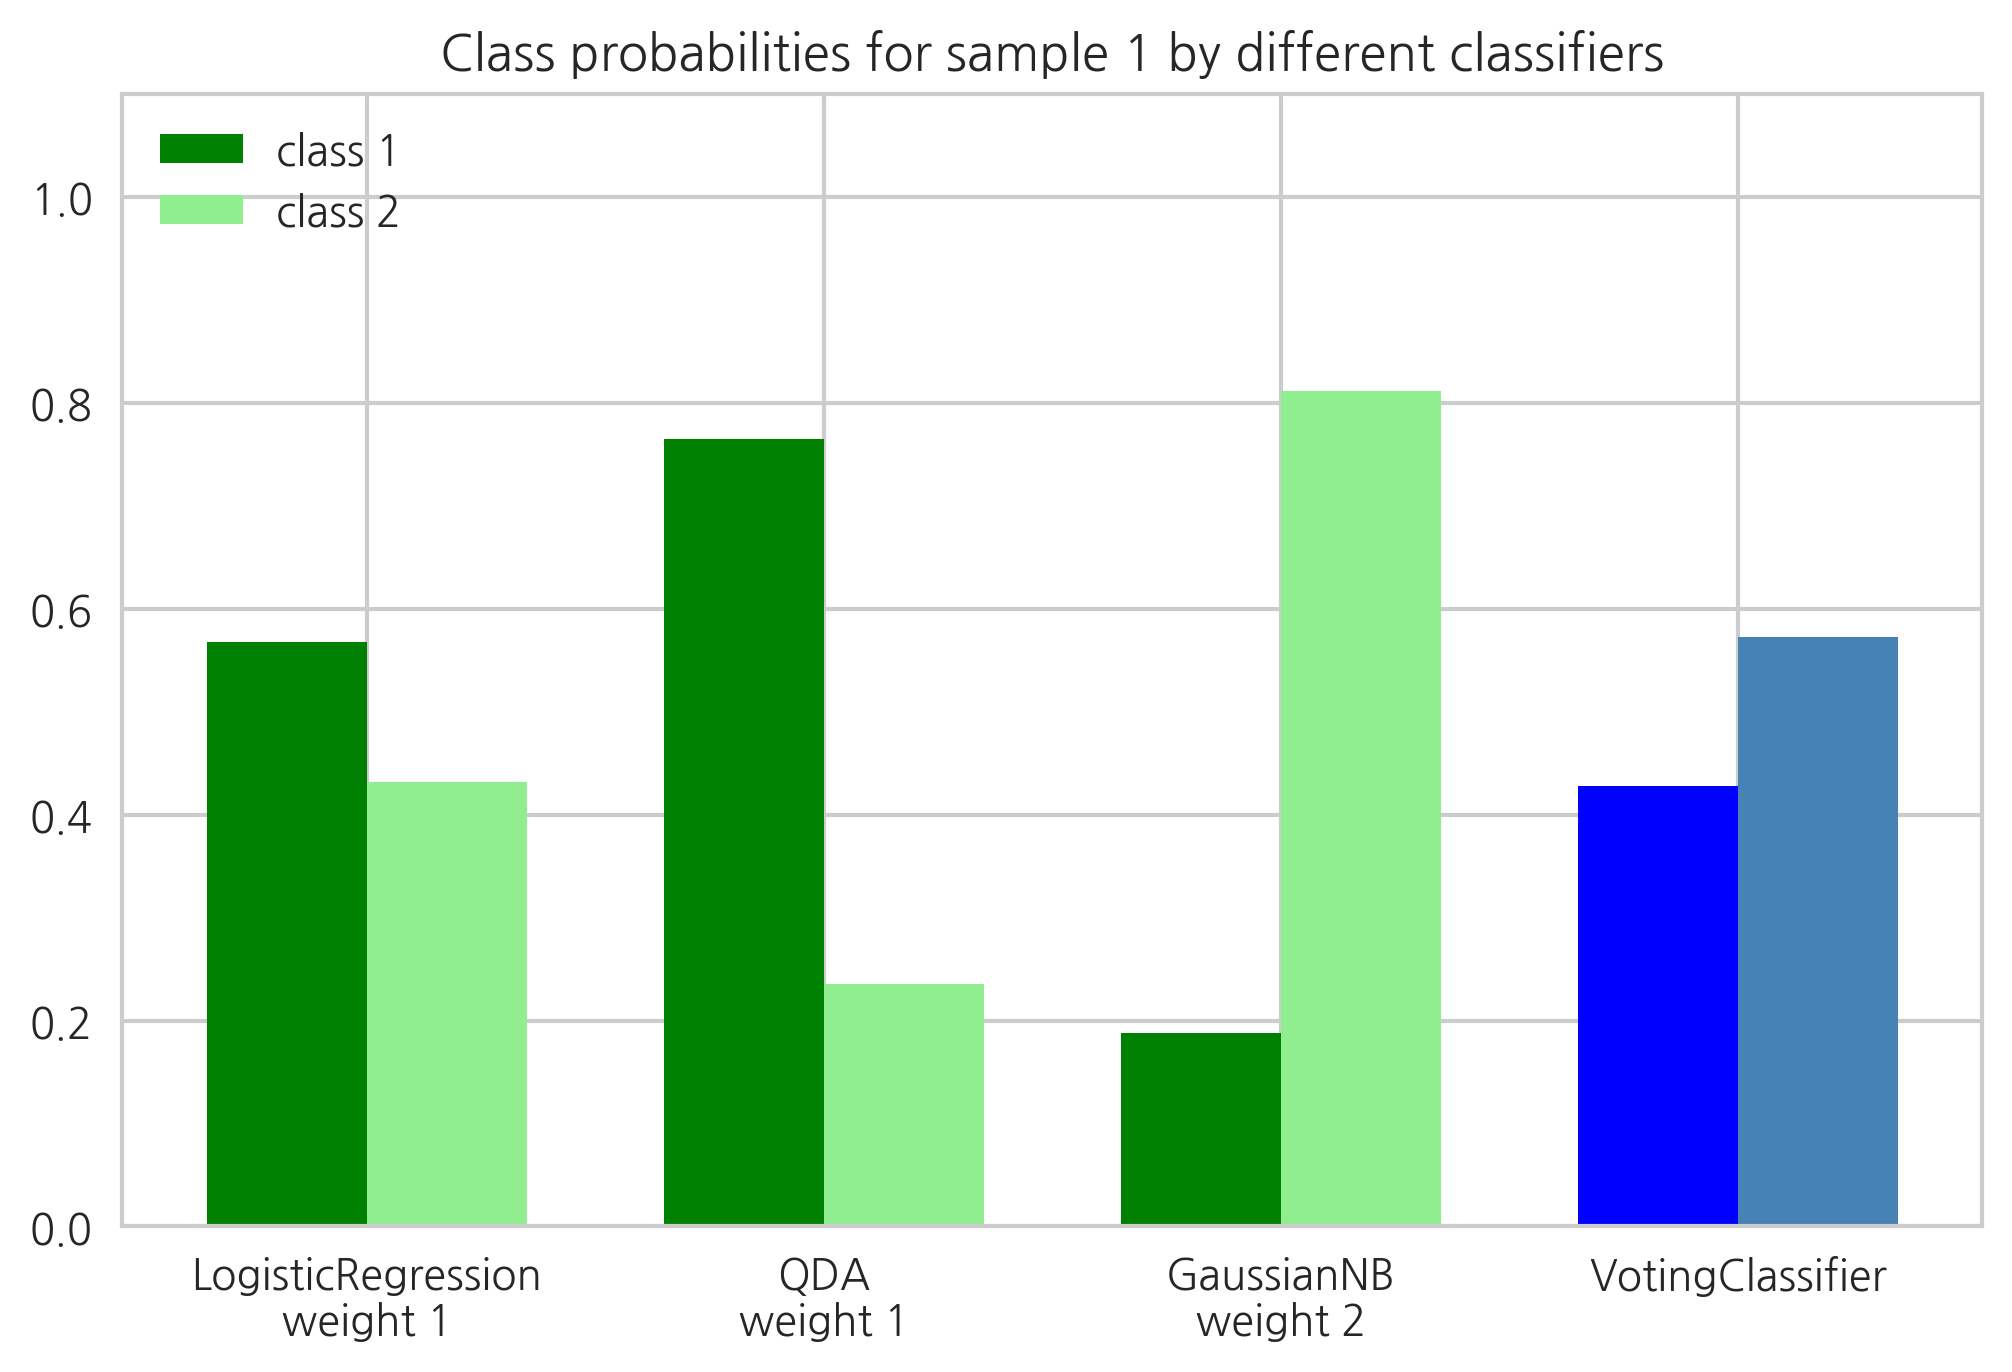

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state=1)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', model1), ('qda', model2), ('gnb', model3)], 
                            voting='soft', weights=[1, 1, 2])

probas = [c.fit(X, y).predict_proba([x_new]) for c in (model1, model2, model3, ensemble)]
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

ind = np.arange(4)
width = 0.35  # bar width
p1 = plt.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = plt.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')
p3 = plt.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = plt.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

plt.xticks(ind + 0.5 * width, ['LogisticRegression\nweight 1',
                               'QDA\nweight 1',
                               'GaussianNB\nweight 2',
                               'VotingClassifier'])
plt.ylim([0, 1.1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.show()

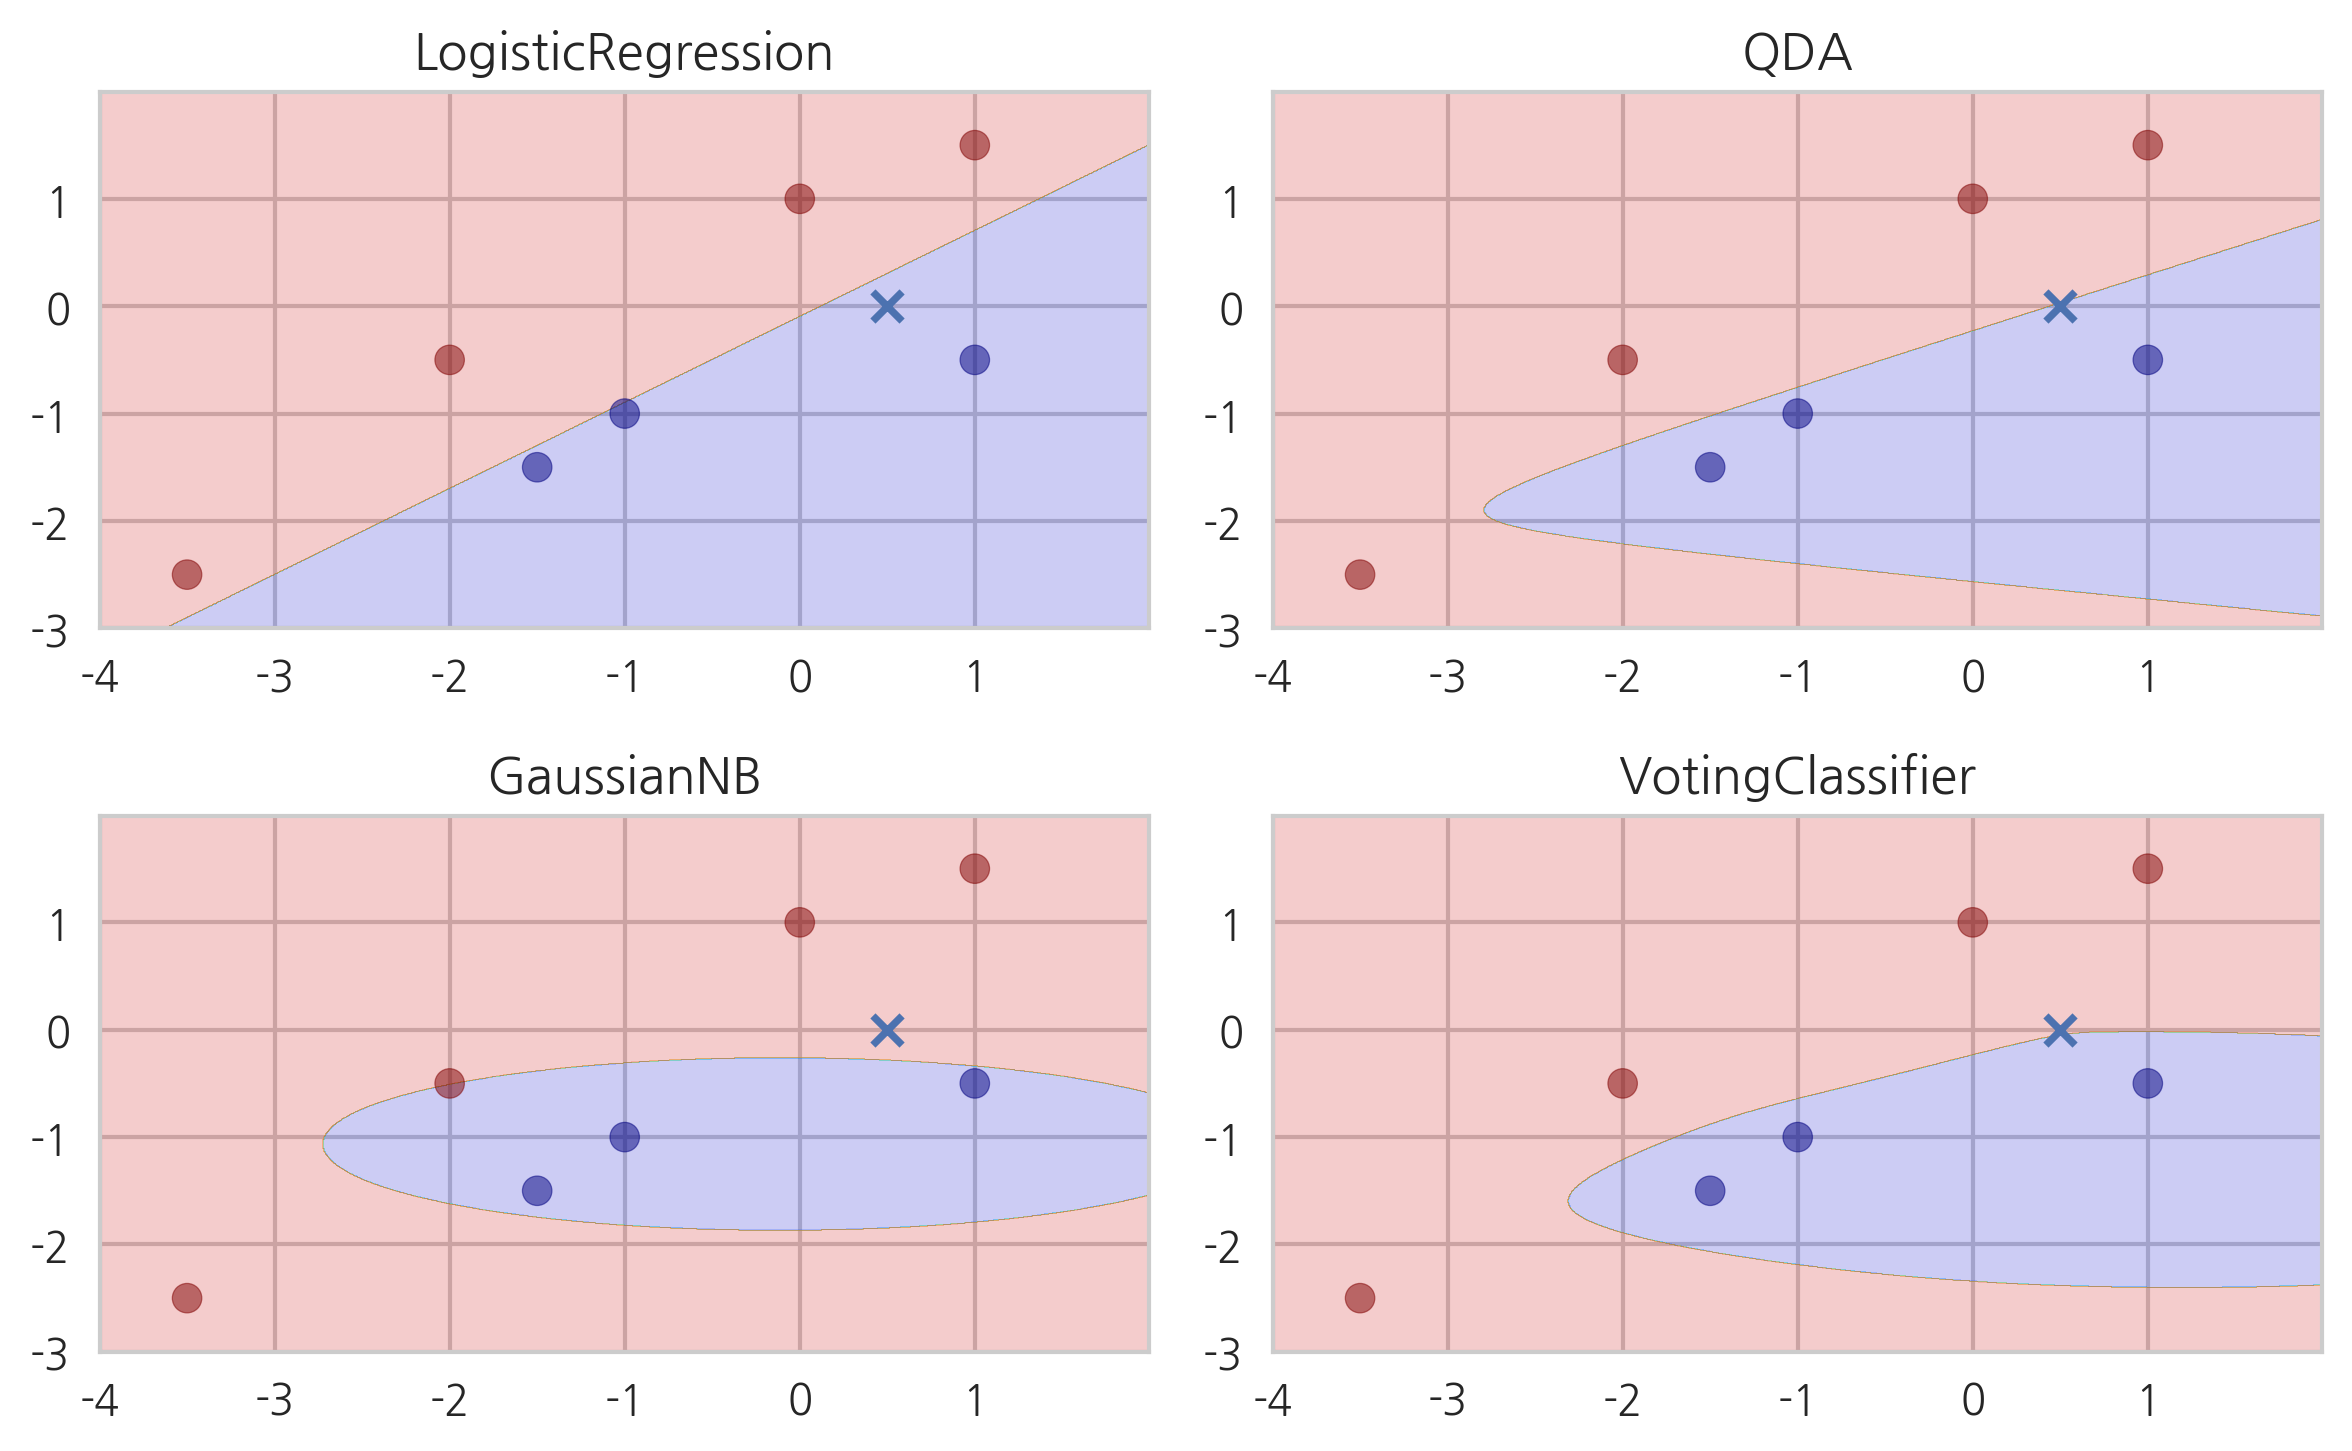

In [3]:
from itertools import product

x_min, x_max = -4, 2
y_min, y_max = -3, 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005), np.arange(y_min, y_max, 0.005))
f, axarr = plt.subplots(2, 2)
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [model1, model2, model3, ensemble],
                        ['LogisticRegression', 'QDA', 'GaussianNB', 'VotingClassifier']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.2, cmap=mpl.cm.jet)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s=50, cmap=mpl.cm.jet)
    axarr[idx[0], idx[1]].scatter(x_new[0], x_new[1], marker='x')
    axarr[idx[0], idx[1]].set_title(tt)
plt.tight_layout()    
plt.show()

## 모형 결합을 사용한 성능 향상

다수결 모형이 개별 모형보다 더 나은 성능을 보이는 이유는 다음 실험에서도 확인 할 수 있다.

만약 어떤 개별 모형이 정답을 출력할 확률이 $p$인 경우에 이러한 모형을 $N$ 개 모아서 다수결 모형을 만들면 정답을 출력할 확률이 다음과 같아진다.


$$ \sum_{k>\frac{N}{2}}^N \binom N k p^k (1-p)^{N-k} $$ 

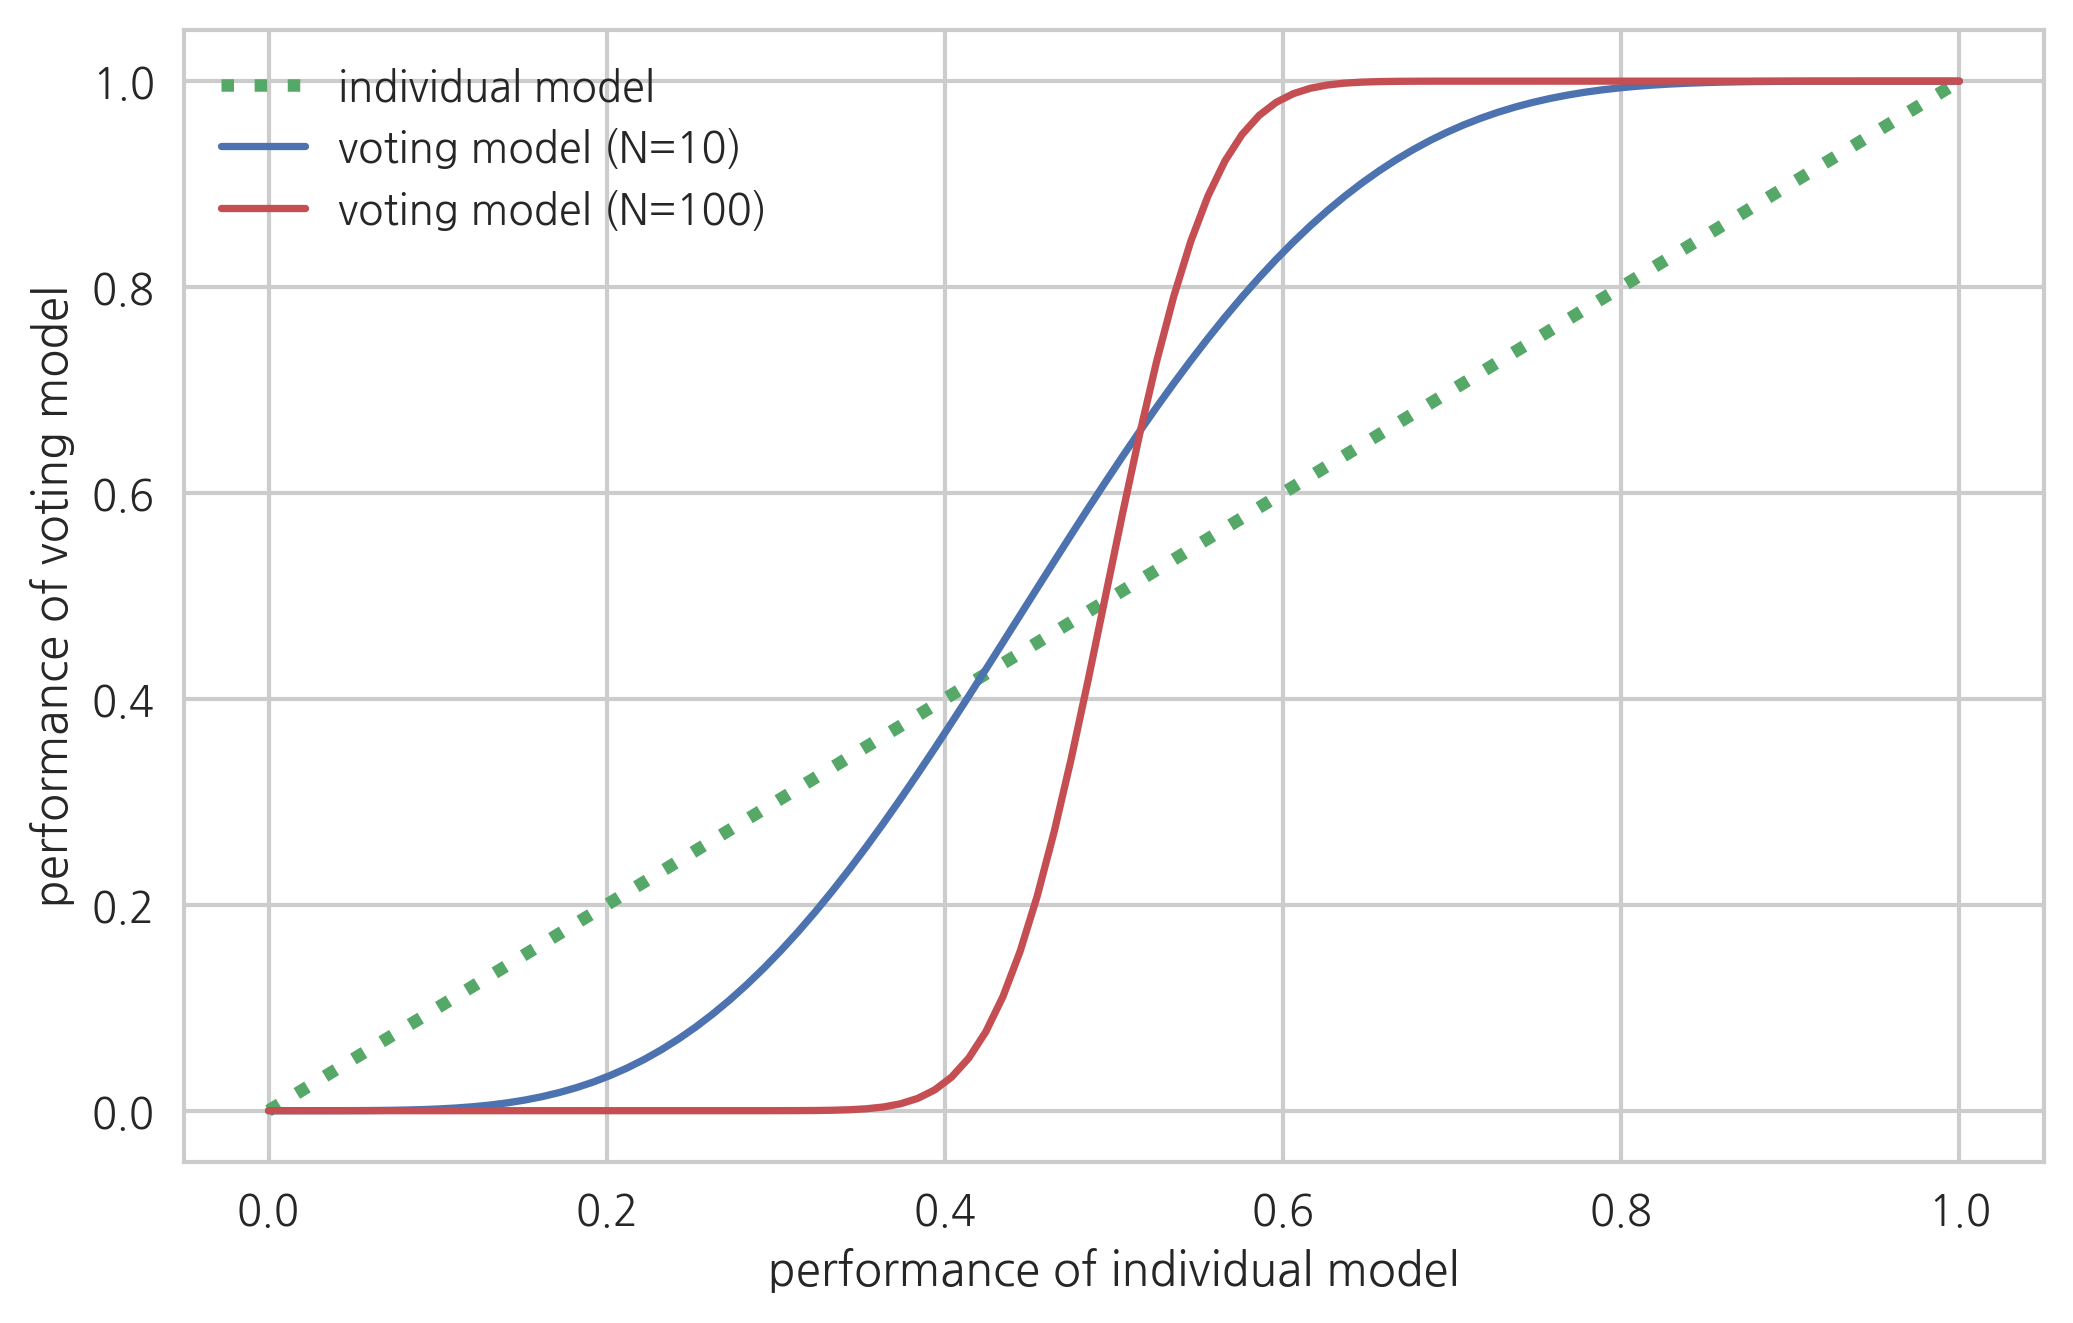

In [4]:
def total_error(p, N):
    te = 0.0
    for k in range(int(np.ceil(N/2)), N + 1):
        te += sp.misc.comb(N, k) * p**k * (1-p)**(N-k)
    return te

x = np.linspace(0, 1, 100)
plt.plot(x, x, 'g:', lw=3, label="individual model")
plt.plot(x, total_error(x, 10), 'b-', label="voting model (N=10)")
plt.plot(x, total_error(x, 100), 'r-', label="voting model (N=100)")
plt.xlabel("performance of individual model")
plt.ylabel("performance of voting model")
plt.legend(loc=0)
plt.show()

## 배깅

앞서 모형 결합에서 사용하는 독립적인 모형의 수가 많을 수록 성능 향상이 일어날 가능성이 높다는 것을 알았다. 각각 다른 확률 모형을 사용하는데에는 한계가 있으므로 보통은 배깅 방법을 사용하여 같은 확률 모형을 쓰지만 서로 다른 결과를 출력하는 다수의 모형을 만든다.

배깅(bagging)은 동일한 모형과 모형 모수를 사용하는 대신 부트스트래핑(bootstrapping)과 유사하게 트레이닝 데이터를 랜덤하게 선택해서 다수결 모형을 적용한다.

트레이닝 데이터를 선택하는 방법에 따라 다음과 같이 부르기도 한다.

* 같은 데이터 샘플을 중복사용(replacement)하지 않으면: Pasting
* 같은 데이터 샘플을 중복사용(replacement)하면 Bagging
* 데이터가 아니라 다차원 독립 변수 중 일부 차원을 선택하는 경우에는: Random Subspaces
* 데이터 샘플과 독립 변수 차원 모두 일부만 랜덤하게 사용하면: Random Patches

성능 평가시에는 트레이닝용으로 선택한 데이터가 아닌 다른 데이터를 사용할 수도 있다. 이런 데이터를 OOB(out-of-bag) 데이터라고 한다.

Scikit-Learn 의  ensemble 서브패키지는 배깅 모형 결합을 위한 [`BaggingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) 클래스를 제공한다. 사용법은 다음과 같다.



`sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)`


* 인수:	
 * `base_estimator`: 
   * 기본 모형
 * `n_estimators`: 정수. 디폴트 10
   * 모형 갯수
 * `max_samples`: 정수 혹은 실수. 디폴트 1.0
   * 데이터 샘플 중 선택할 샘플의 수 혹은 비율
 * `max_features`: 정수 혹은 실수. 디폴트 1.0
   * 다차원 독립 변수 중 선택할 차원의 수 혹은 비율
 * `bootstrap`: 불리언, 디폴트 True
   * 데이터 중복 사용 여부
 * `bootstrap_features`: 불리언, 디폴트 False
   * 차원 중복 사용 여부
 * `oob_score`: 불리언 디폴트 False
   * 성능 평가시 OOB(out-of-bag) 샘플 사용 여부

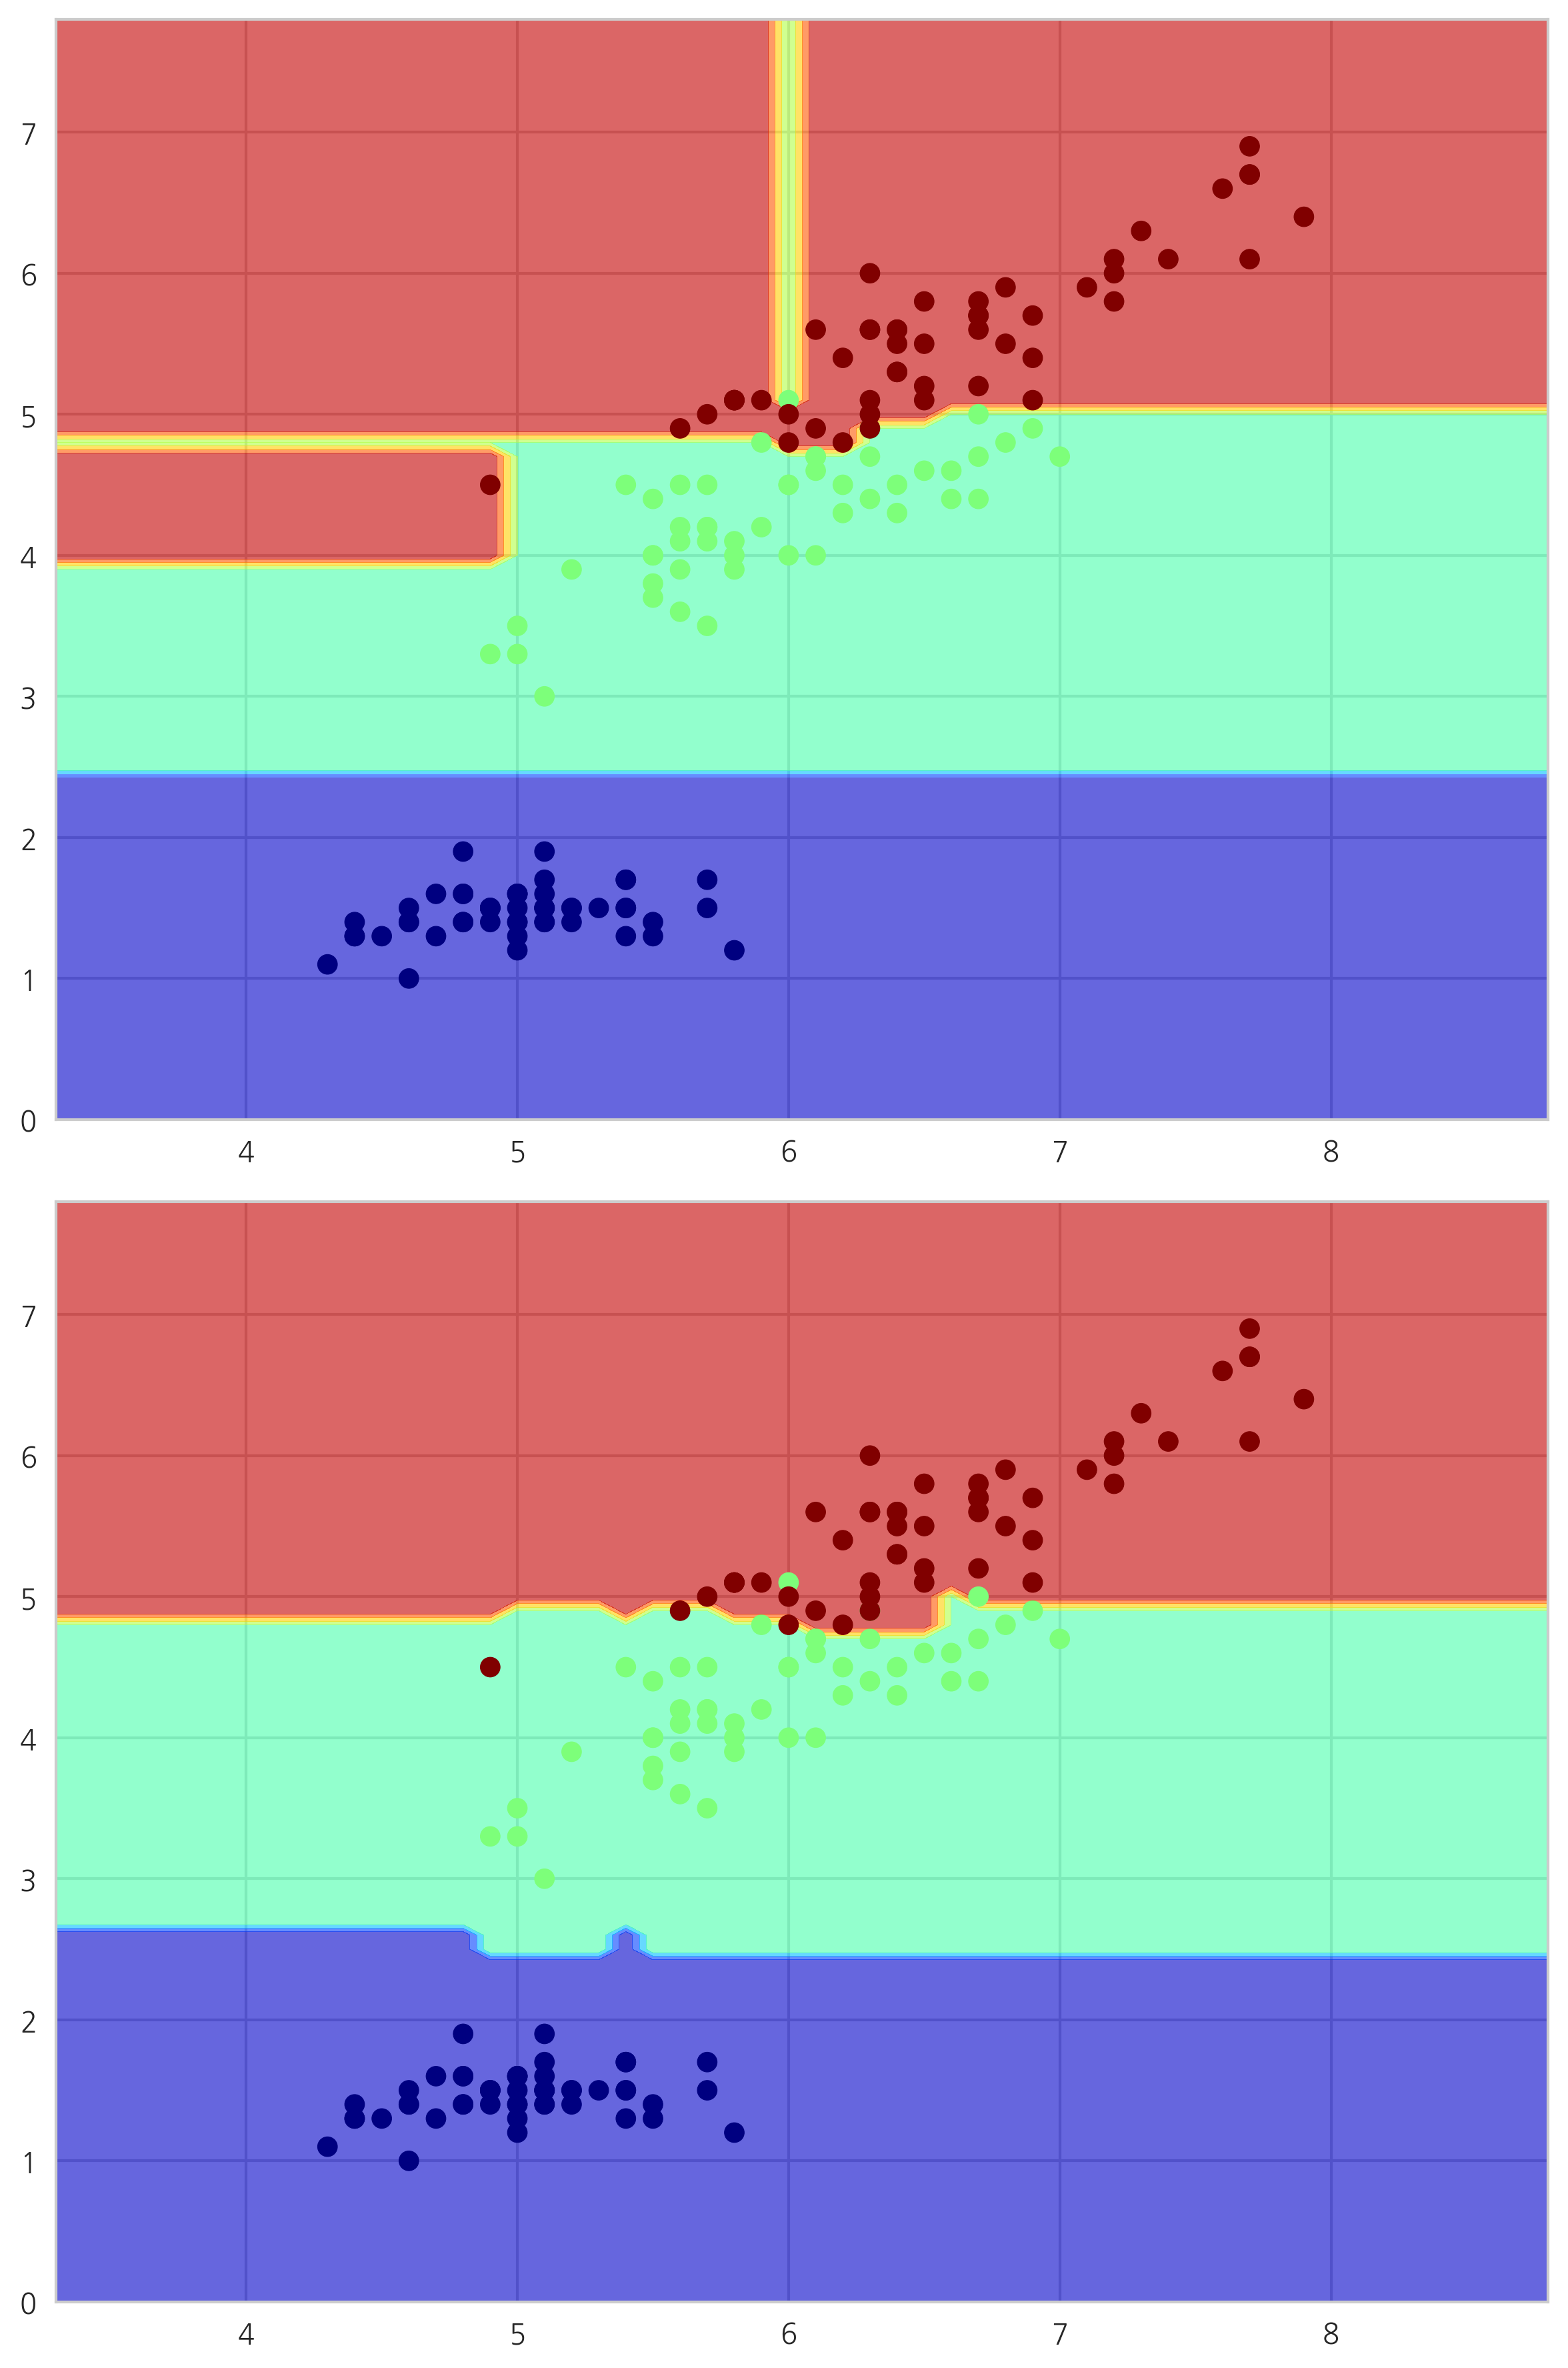

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target

model1 = DecisionTreeClassifier().fit(X, y)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(8,12))

plt.subplot(211)
Z1 = model1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet)

plt.subplot(212)
Z2 = model2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet)

plt.tight_layout()
plt.show()

## 랜덤 포레스트

랜덤 포레스트(Random Forest)는 의사 결정 나무(Decision Tree)를 개별 모형으로 사용하는 모형 결합 방법을 말한다.

배깅과 마찬가지로 데이터 샘플의 일부만 선택하여 사용한다. 하지만 노드 분리시 모든 독립 변수들을 비교하여 최선의 독립 변수를 선택하는 것이 아니라 독립 변수 차원을 랜덤하게 감소시킨 다음 그 중에서 독립 변수를 선택한다. 이렇게 하면 개별 모형들 사이의 상관관계가 줄어들기 때문에 모형 성능의 변동이 감소하는 효과가 있다.

이러한 방법을 극단적으로 적용한 것이 Extremely Randomized Trees 모형으로 이 경우에는 각 노드에서 랜덤하게 독립 변수를 선택한다.

랜덤 포레스트와 Extremely Randomized Trees 모형은 각각 `RandomForestClassifier`클래스와 `ExtraTreesClassifier` 클래스로 구현되어 있다.

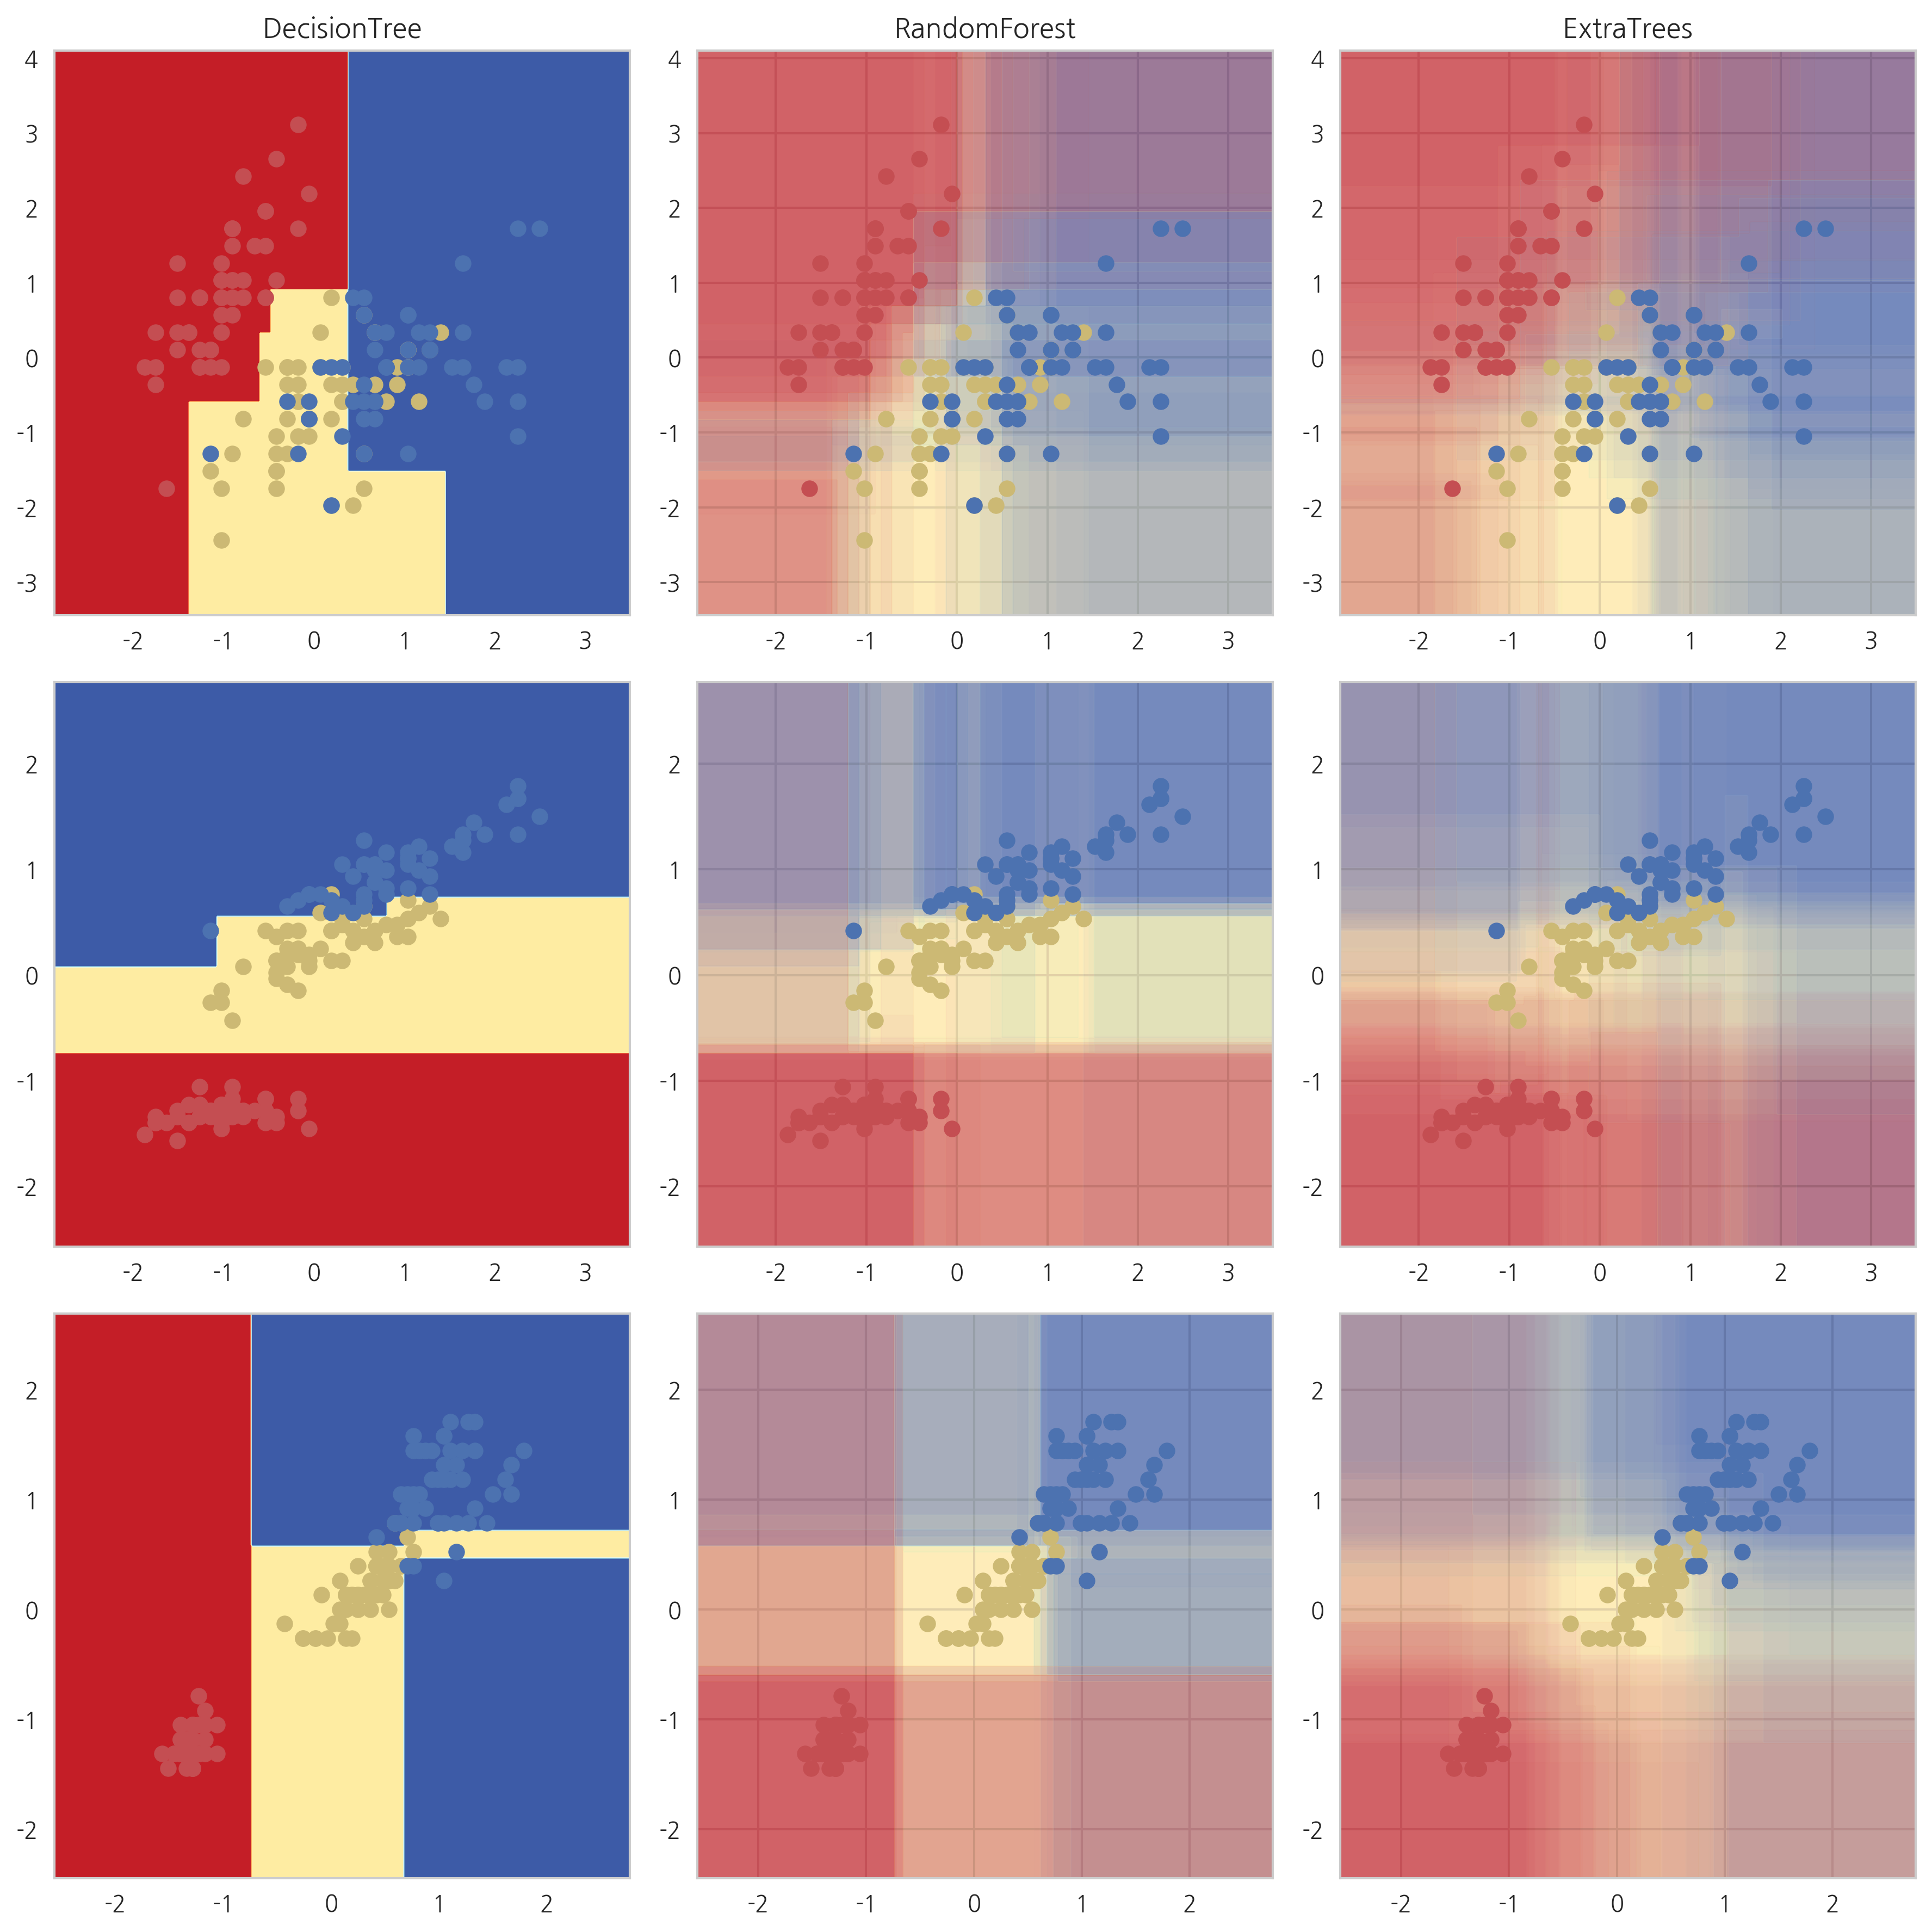

In [6]:
from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()

n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02
seed = 13

models = [DecisionTreeClassifier(max_depth=4),
          RandomForestClassifier(max_depth=4, n_estimators=n_estimators),
          ExtraTreesClassifier(max_depth=4, n_estimators=n_estimators)]

plot_idx = 1
plt.figure(figsize=(12, 12))
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        X = iris.data[:, pair]
        y = iris.target

        idx = np.arange(X.shape[0])
        np.random.seed(seed)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        clf = clone(model)
        clf = model.fit(X, y)

        plt.subplot(3, 3, plot_idx)
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        if plot_idx <= len(models):
            plt.title(model_title)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        for i, c in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c,
                        label=iris.target_names[i], cmap=cmap)

        plot_idx += 1

plt.tight_layout()
plt.show()

랜덤 포레스트의 장점 중 하나는 각 독립 변수의 중요도(feature importance)를 계산할 수 있다는 점이다.

포레스트 안에서 사용된 모든 노드에 대해 어떤 독립 변수를 사용하였고 그 노드에서 얻은 information gain을 구할 수 있으므로 각각의 독립 변수들이 얻어낸 information gain의 평균을 비교하면 어떤 독립 변수가 중요한지를 비교할 수 있다.

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


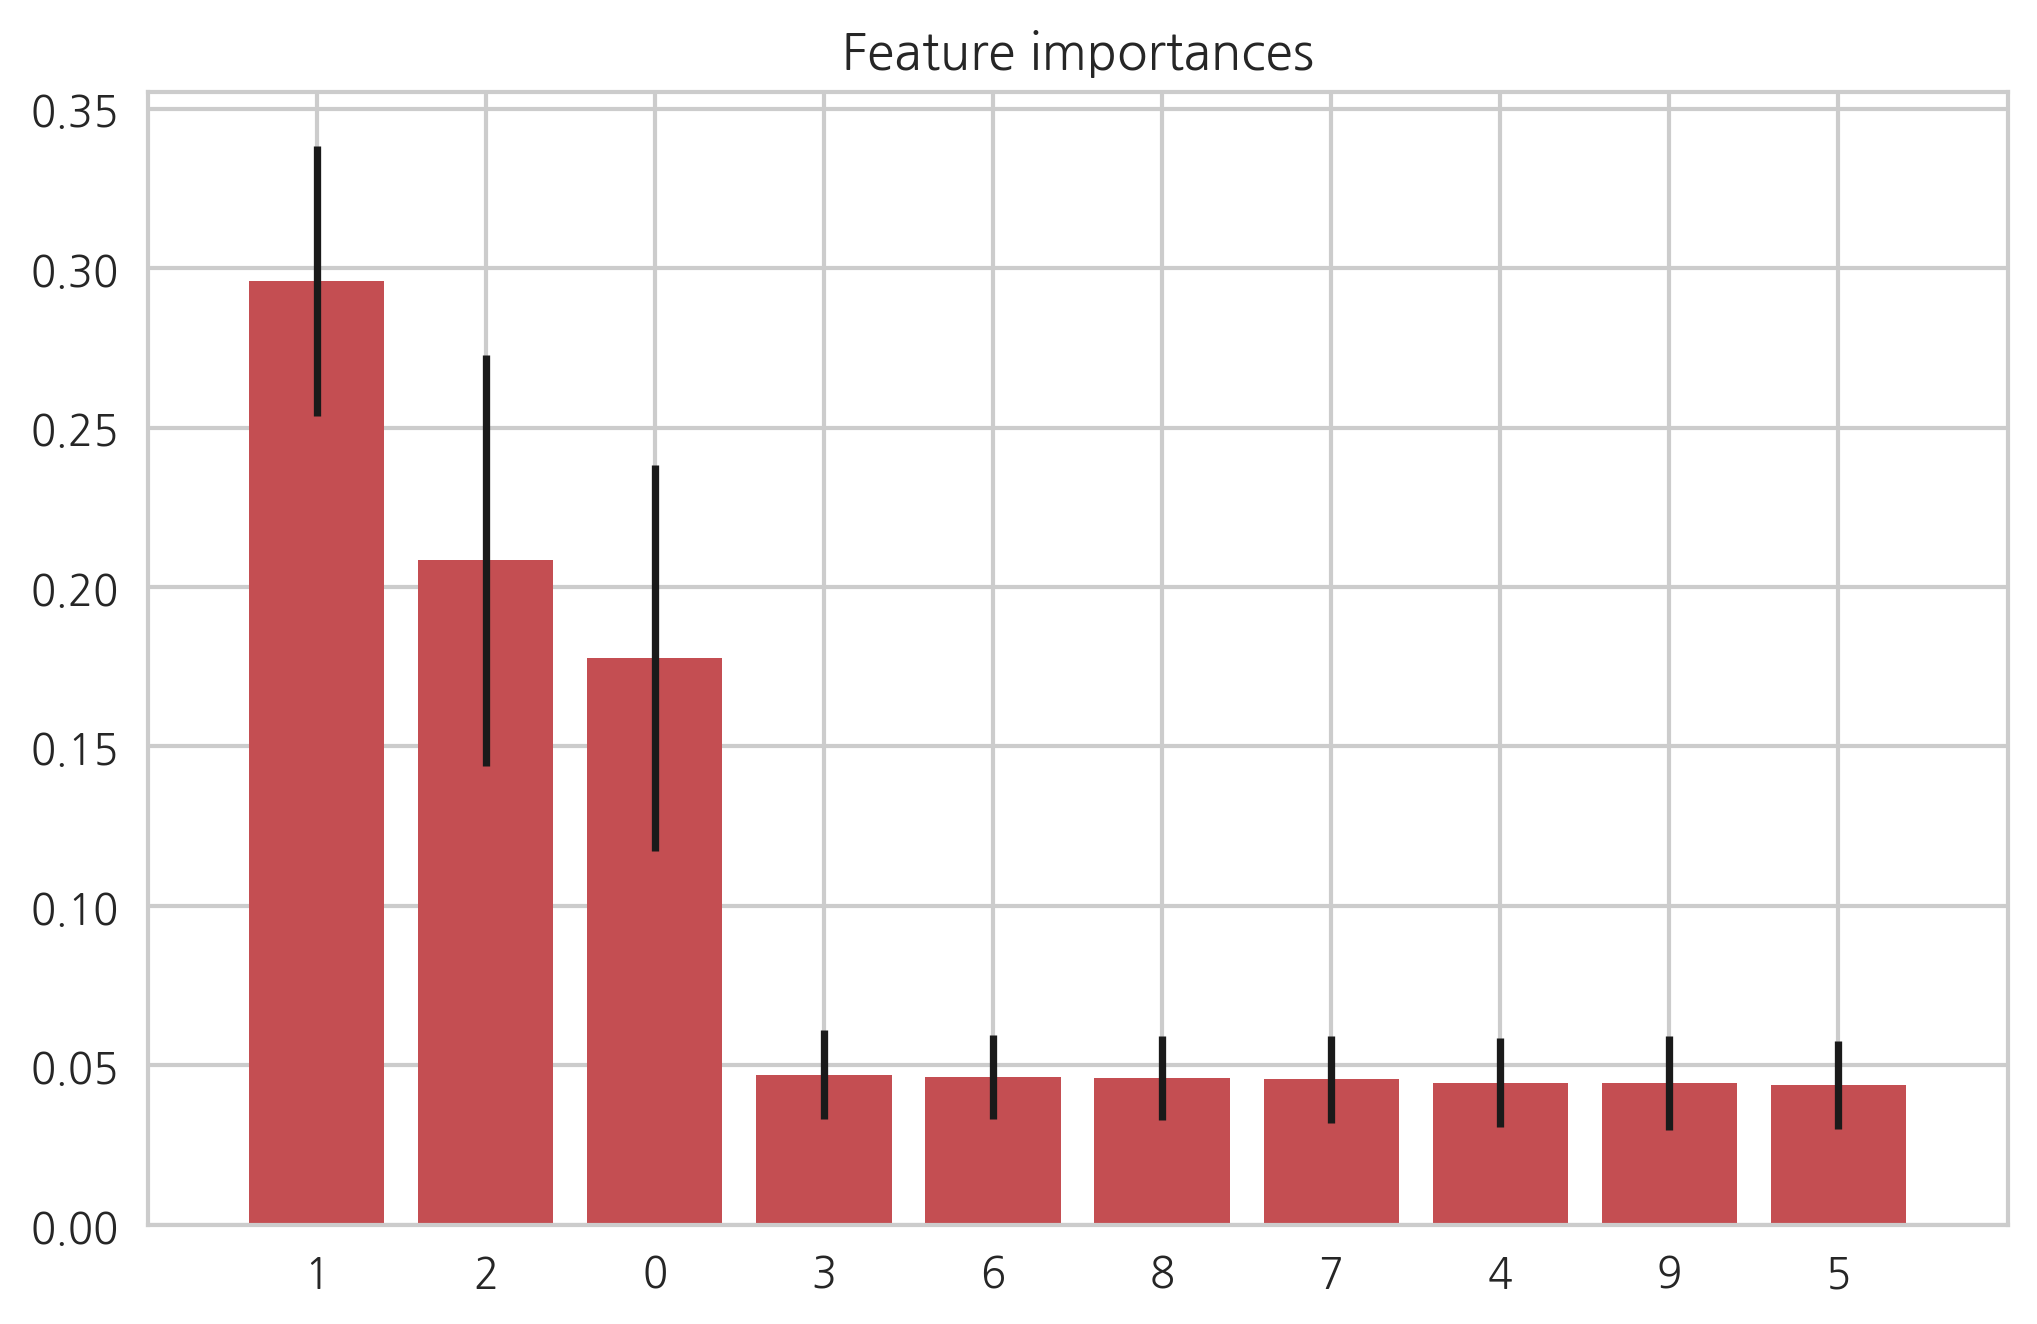

In [7]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0, n_repeated=0,
                           n_classes=2, random_state=0, shuffle=False)

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

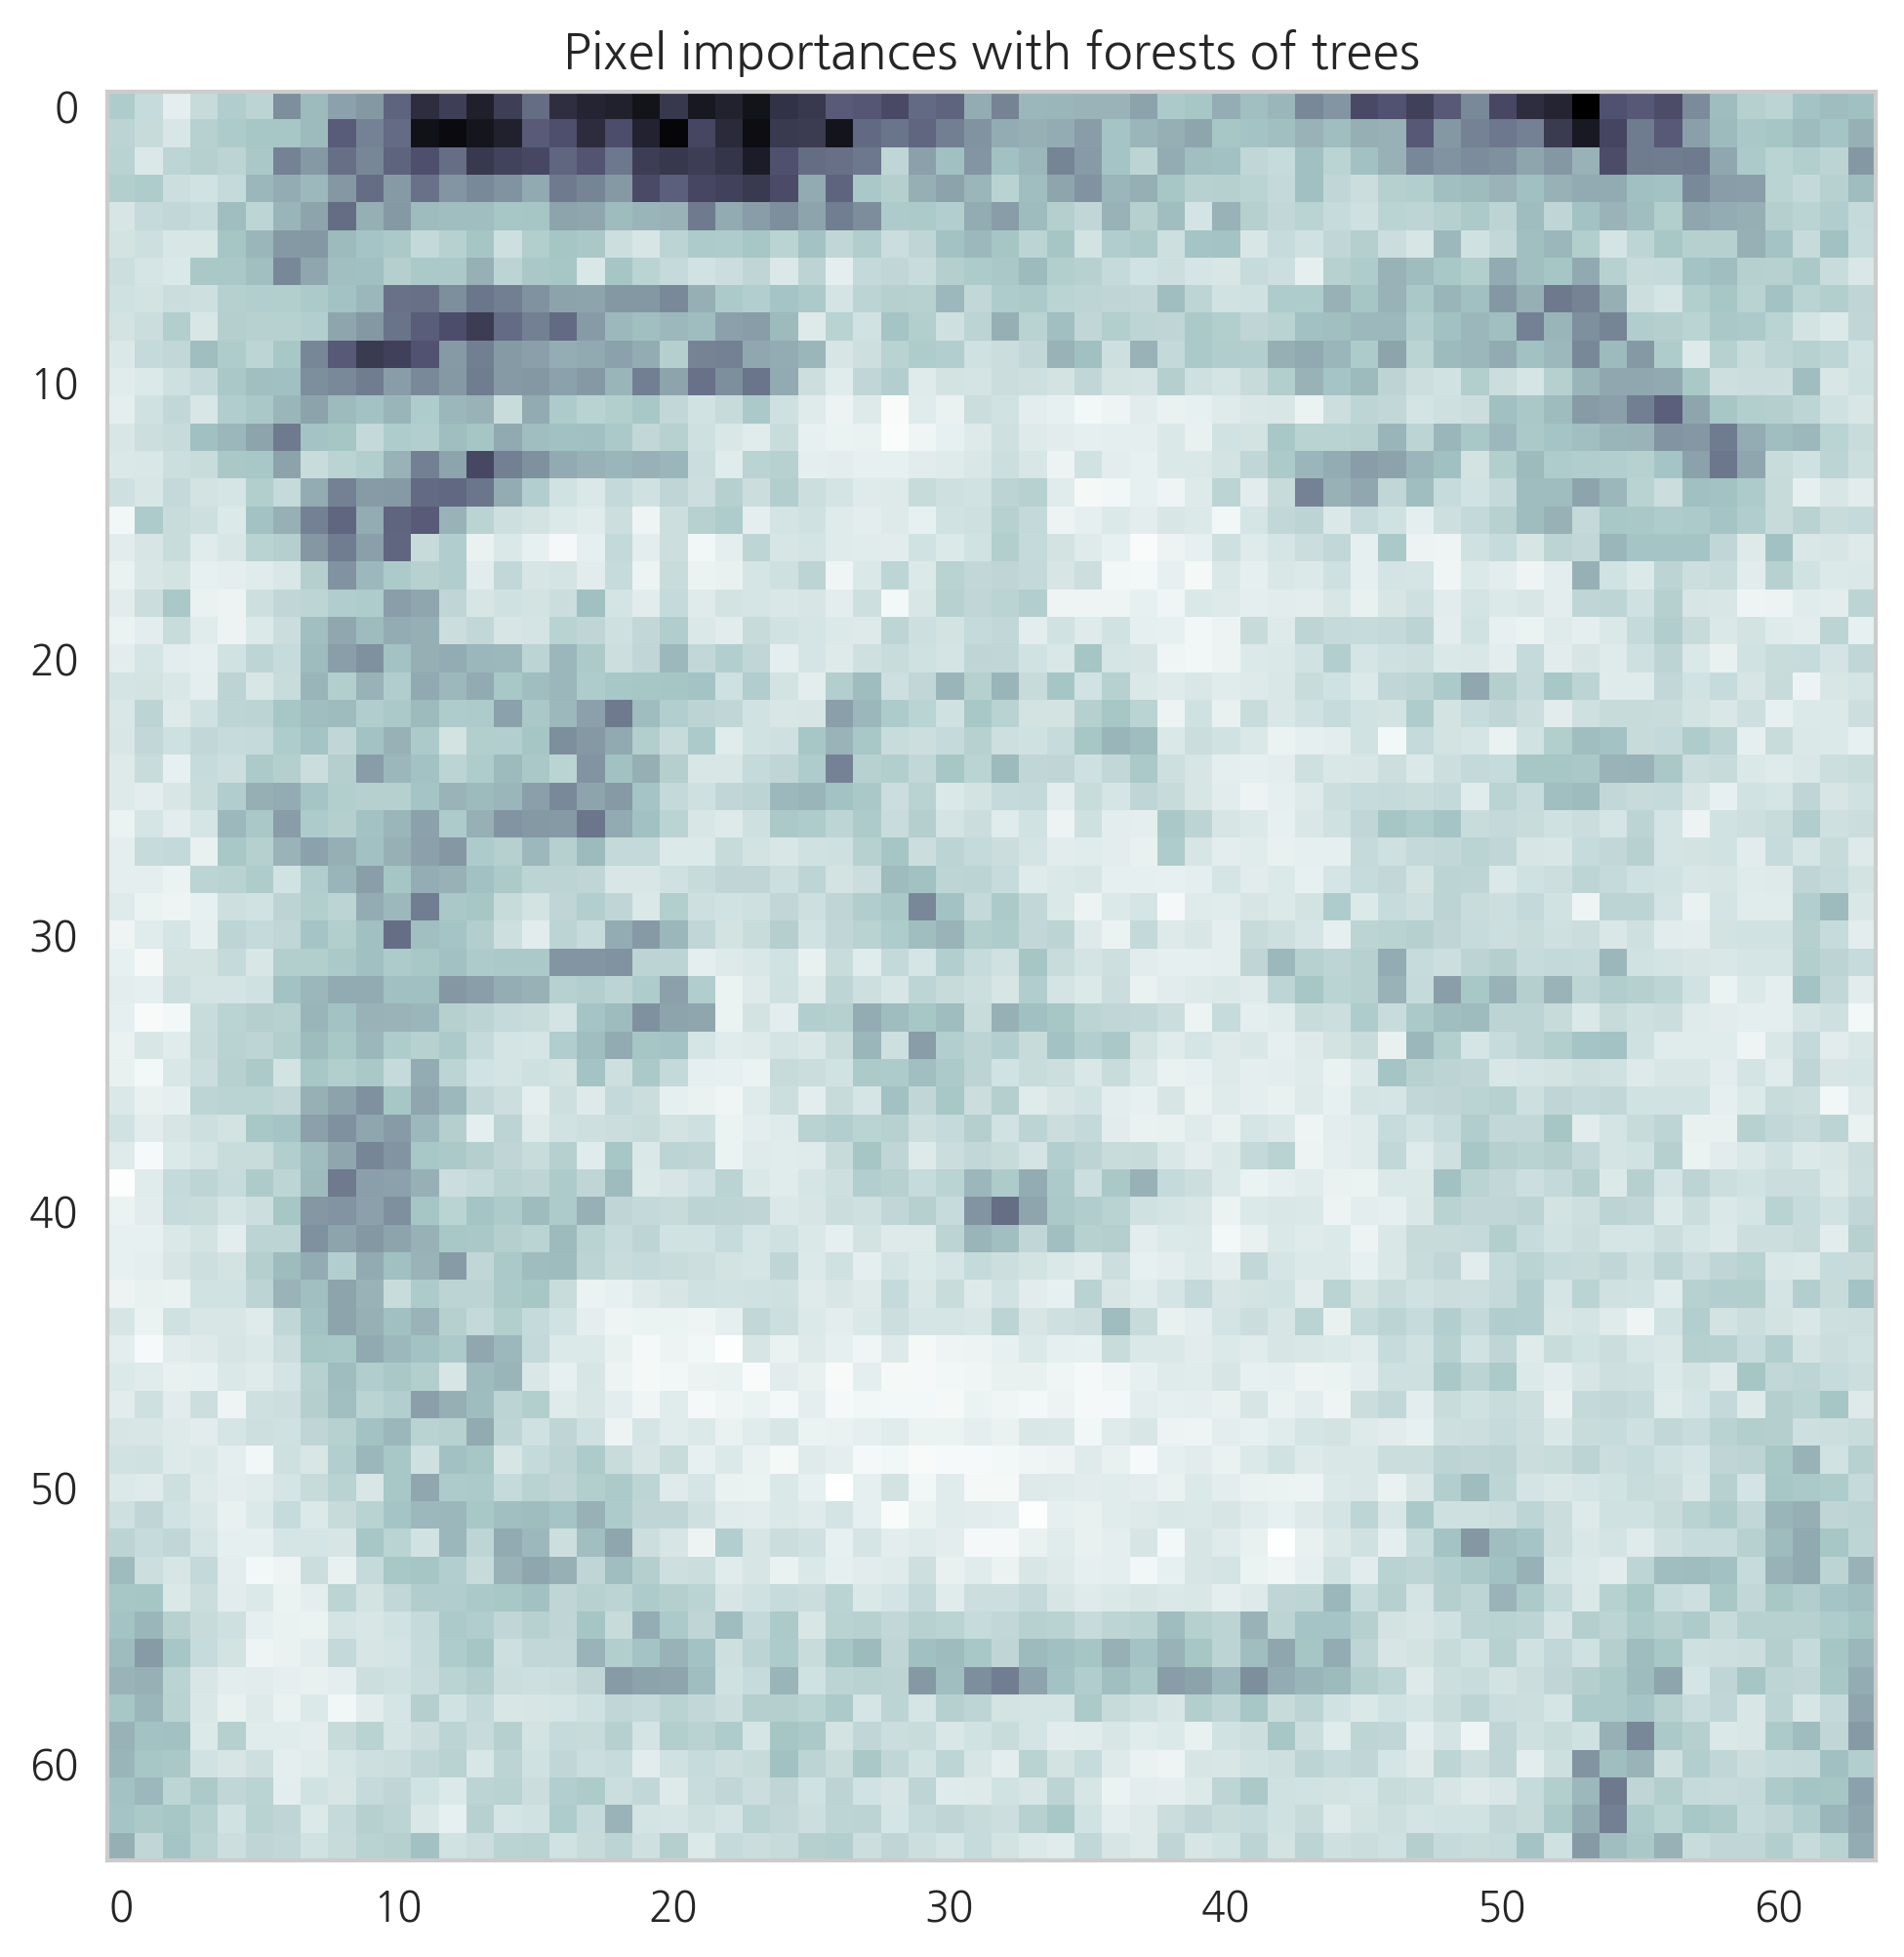

In [10]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

data = fetch_olivetti_faces()
X = data.data
y = data.target

forest = ExtraTreesClassifier(n_estimators=1000, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

plt.figure(figsize=(8, 8))
plt.imshow(importances, cmap=plt.cm.bone_r)
plt.grid(False)
plt.title("Pixel importances with forests of trees")
plt.show()